In [8]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pl_temp_fit import Exp_data_utils, config_utils

os.chdir("C:\\Users\\ma11115\\OneDrive - Imperial College London\\fit_pl_database_Hanbo")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [103]:
blobs["Ex_knr"].mean()

309849665.96326786

In [106]:


databse_path = Path("fit_experimental_emcee_PL","fit_data_base","n=2")
df_dict = {}
for n in  range(1,6):
    databse_path = Path("fit_experimental_emcee_PL","fit_data_base",f"n={n}")

    json_files = list(databse_path.glob("*.json"))
    list_model_config = []
    for _id, json_file in enumerate(json_files):
        model_config, model_config_save = config_utils.load_model_config(
            json_file.name.replace(".json", ""),
            database_folder=databse_path,
        )
        if os.path.exists(model_config_save["save_folder"] + "/sampler.h5"):
            filename = model_config_save["save_folder"] + "/sampler.h5"
            try:
                reader = emcee.backends.HDFBackend(filename, name="multi_core")
                if not reader.initialized:
                    print("multi_core empty file")
                    continue
                if reader.iteration == 0:
                    print("empty file")
                    continue
                distribution = reader.get_chain(flat=True)
            except AttributeError:
                print("check if single core")

                reader = emcee.backends.HDFBackend(filename, name="single_core")
                if not reader.initialized:
                    print("empty file")
                    continue
                distribution = reader.get_chain(flat=True)

            true_parameters = list(np.mean(distribution, axis=0))
            model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
            model_config_save["num_iteration"] = reader.iteration
            log_prob = reader.get_log_prob(flat=True)
            model_config_save["max_log_prob"] = np.max(log_prob)
            blobs = reader.get_blobs(flat=True,discard=100)
            model_config_save["mean_lifetime"] = 1/(blobs["Ex_knr"].mean()+blobs["Ex_kr"].mean())*1e9

            list_model_config.append(model_config_save)
    if len(list_model_config) == 0:
        print("no data")
    else:
        df_all = pd.DataFrame(list_model_config)
        df_all.sort_values(by="date", ascending=False, inplace=True)
        df_dict[n] = df_all
df_all[["csv_name_PL", "num_iteration", "max_log_prob","mean_lifetime"]]

In [95]:
search_for = "Y5"
df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]]

,csv_name_PL,num_iteration,max_log_prob
12,cryostat/60-300K/Y5-soln.csv,10000,-614.835562
11,cryostat/60-300K/Y5-soln.csv,10000,-815.013182
9,cryostat/60-300K/Y5-soln.csv,10000,-748.716761


In [31]:
for key, df_all in df_dict.items():
    search_for = "Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s"
    df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]].index.values

In [32]:
 df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]].index.values

array([21, 17, 28, 25], dtype=int64)

Text(29.140625, 0.5, '$\\hbar \\omega_{0}$ (eV)')

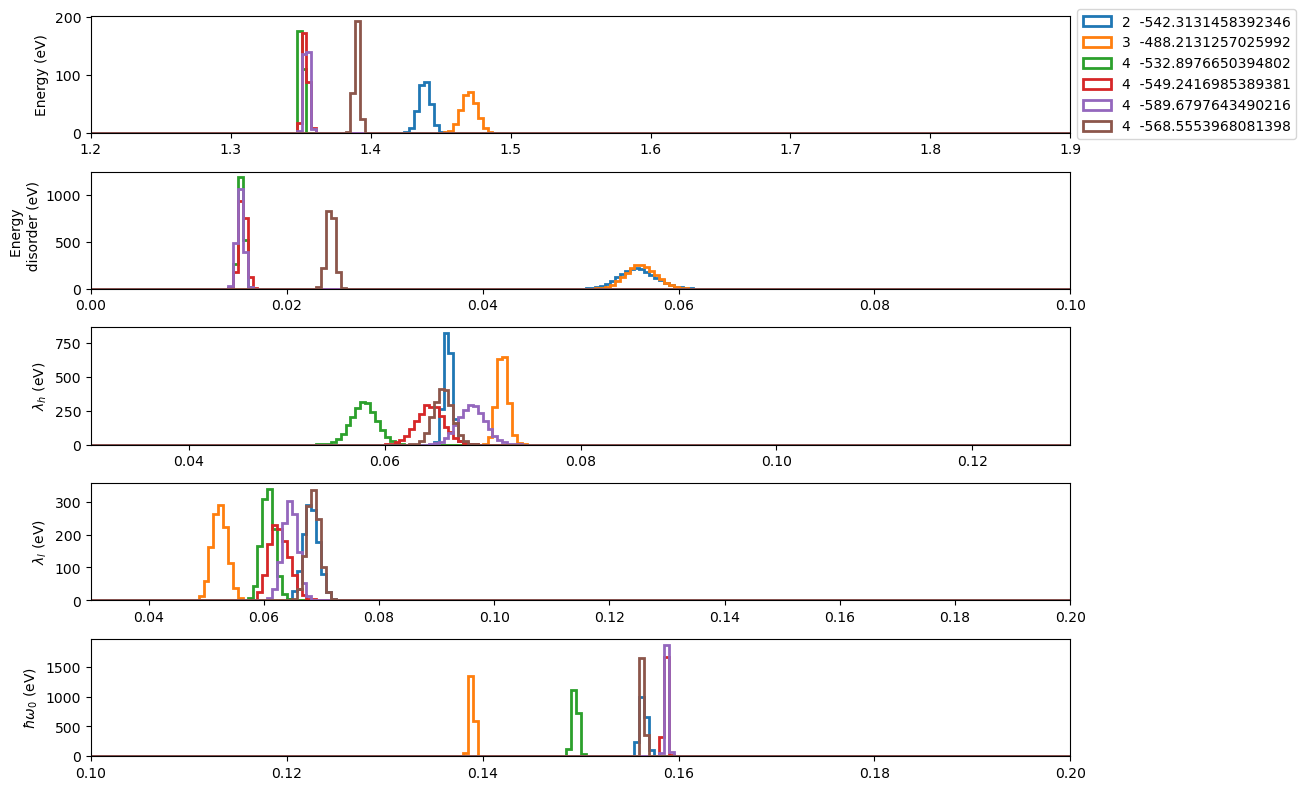

In [45]:
import importlib
from pl_temp_fit import plot_utils

def plot_distribution_multi(
    reader, model_config_save, discard=10, filter_log_likelihood=True,
    fig=None,axes=None,legend_label='test',color='C1'
):
    """plot the distribution of the parameters from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
    labels = label_list
    ndim = len(labels)

    distribution = reader.get_chain(discard=discard, flat=True)
    if filter_log_likelihood:
        blobs = reader.get_blobs(flat=True, discard=discard)
        distribution = distribution[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.05
        ]
    if fig is None:
        fig, axes = plt.subplots(5, figsize=(12, 12))
    axes_xlim = [[1.2, 1.9], [0, 0.1], [0.03, 0.13], [0.03, 0.2], [0.1, 0.2]]
    for i in range(ndim):
        ax = axes[i]
        ax.hist(
            distribution[:, i],
            200,
            color=color,
            linewidth=2,
            histtype="step",
            label=legend_label,
            range = (axes_xlim[i][0],axes_xlim[i][1]),
            density=True,
        )
        ax.set_ylabel(labels[i])
        ax.set_xlim(axes_xlim[i])
    axes[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    return fig, axes

importlib.reload(plot_utils)
fig, axes = plt.subplots(5, figsize=(13, 8))
color_list = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
counter = -1
for n in range(1,5):

    databse_path = Path("fit_experimental_emcee_PL","fit_data_base",f"n={n}")
    df_all = df_dict[n]
    index_analyse_list = df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]].index.values
    for i, index_analyse in enumerate(index_analyse_list):
        test_id = df_all["test_id"].loc[index_analyse]
        if df_all["max_log_prob"].loc[index_analyse] <-600: 
            continue
        counter = counter +1    
        label = f"{n}  "+ str (
            df_all["max_log_prob"]
            .loc[index_analyse]
        )
        model_config, model_config_save = config_utils.load_model_config(
            test_id, database_folder=databse_path
        )
        filename = model_config_save["save_folder"] + "/sampler.h5"
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        fig, ax = plot_distribution_multi(
            reader,
            model_config_save,
            discard=200,
            filter_log_likelihood=True,
            fig=fig,
            axes=axes,
            color=color_list[counter],
            legend_label=label,
        )
ax[0].set_ylabel("Energy (eV)")
ax[1].set_ylabel("Energy \n  disorder (eV)")
ax[2].set_ylabel("$\lambda_{h}$ (eV)")
ax[3].set_ylabel("$\lambda_{l}$ (eV)")
ax[4].set_ylabel("$\hbar \omega_{0}$ (eV)")
#ax[0].legend(label_list,loc="center left",ncols=7,bbox_to_anchor=(-0.2, 1.2),fontsize=12)


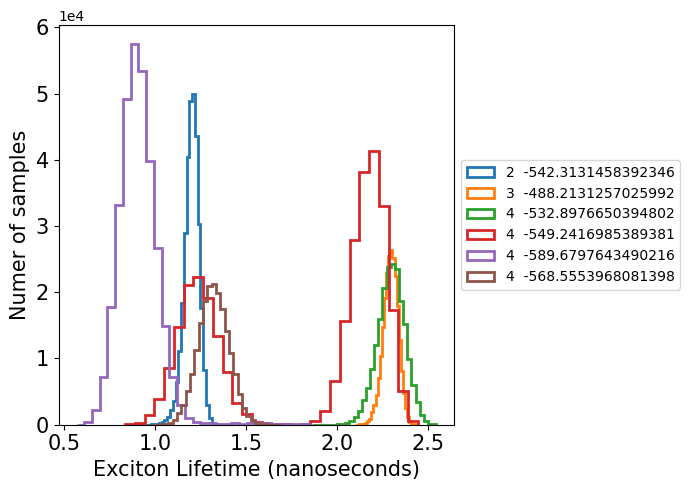

In [68]:
def plot_lifetime_multi(
        counter,
    discard=5,
    temperature=300,
    filter_log_likelihood=False,
):
    """plot the lifetime distribution from the sampling output
    reader: the reader object from the emcee sampler
    range_chi_square: the range for the chi square plot
    range_log_prior: the range for the log prior plot
    discard: the number of samples to discard
    temperature: the temperature at which the lifetime is calculated
    """

    for i, index_analyse in enumerate(index_analyse_list):
        test_id = df_all["test_id"].loc[index_analyse]
        if df_all["max_log_prob"].loc[index_analyse] <-600: 
            continue
        counter = counter +1   
        label = (
            df_all["csv_name_PL"]
            .loc[index_analyse]
            .split("/")[-1]
            .replace(".csv", "")
            .replace("_mod_split", " ")
            .replace("_split", " ")
        )
        model_config, model_config_save = config_utils.load_model_config(
            test_id, database_folder=databse_path
        )
        filename = model_config_save["save_folder"] + "/sampler.h5"
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        blobs = reader.get_blobs(flat=True, discard=discard)
        if filter_log_likelihood:
            blobs = blobs[
                blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
            ]
        lifetime = 1 / (blobs["Ex_kr"] + blobs["Ex_knr"])
        label = f"{n}  "+ str (
            df_all["max_log_prob"]
            .loc[index_analyse]
        )
        ax.hist(
            lifetime * 1e9,
            30,
            histtype="step",
            color=color_list[counter],
            linewidth=2,
            label=label,
        )
        ax.set_xlabel("Exciton Lifetime (nanoseconds)", fontsize=15)
        ax.set_ylabel("Numer of samples", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))   
        # set y ticks to exponent form
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    fig.tight_layout()
    return fig, ax,counter
importlib.reload(plot_utils)
fig, ax = plt.subplots(1,1, figsize=(7, 5))
counter = -1
for n in range(1,5):
    databse_path = Path("fit_experimental_emcee_PL","fit_data_base",f"n={n}")
    df_all = df_dict[n]
    index_analyse_list = df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]].index.values
    fig, ax, counter= plot_lifetime_multi(counter ,discard=100, filter_log_likelihood=True)


shape of mean value plot is (95, 7)


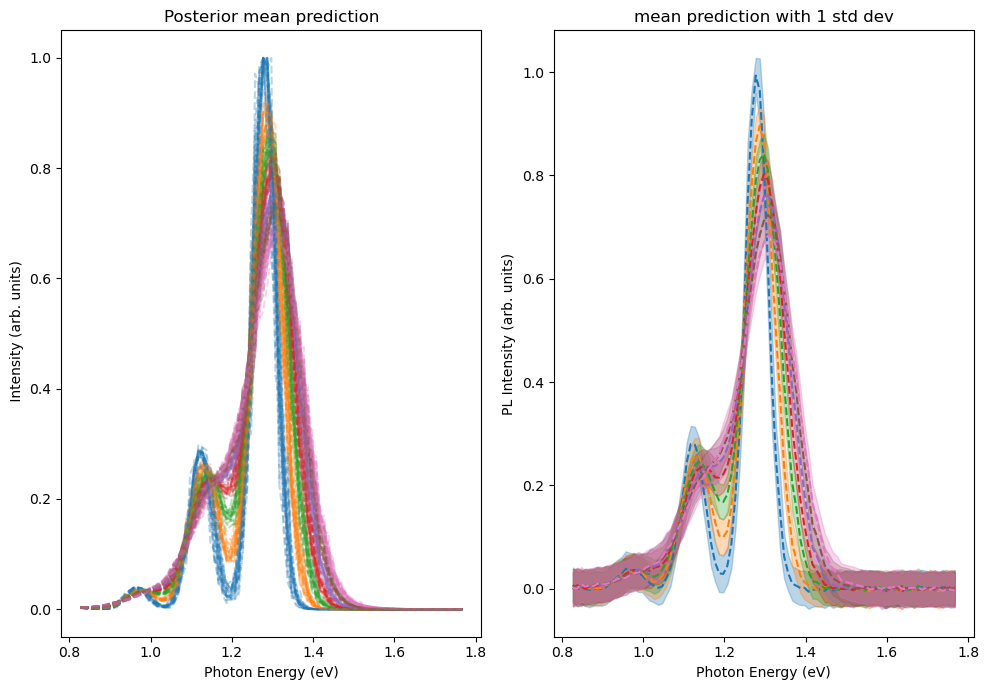

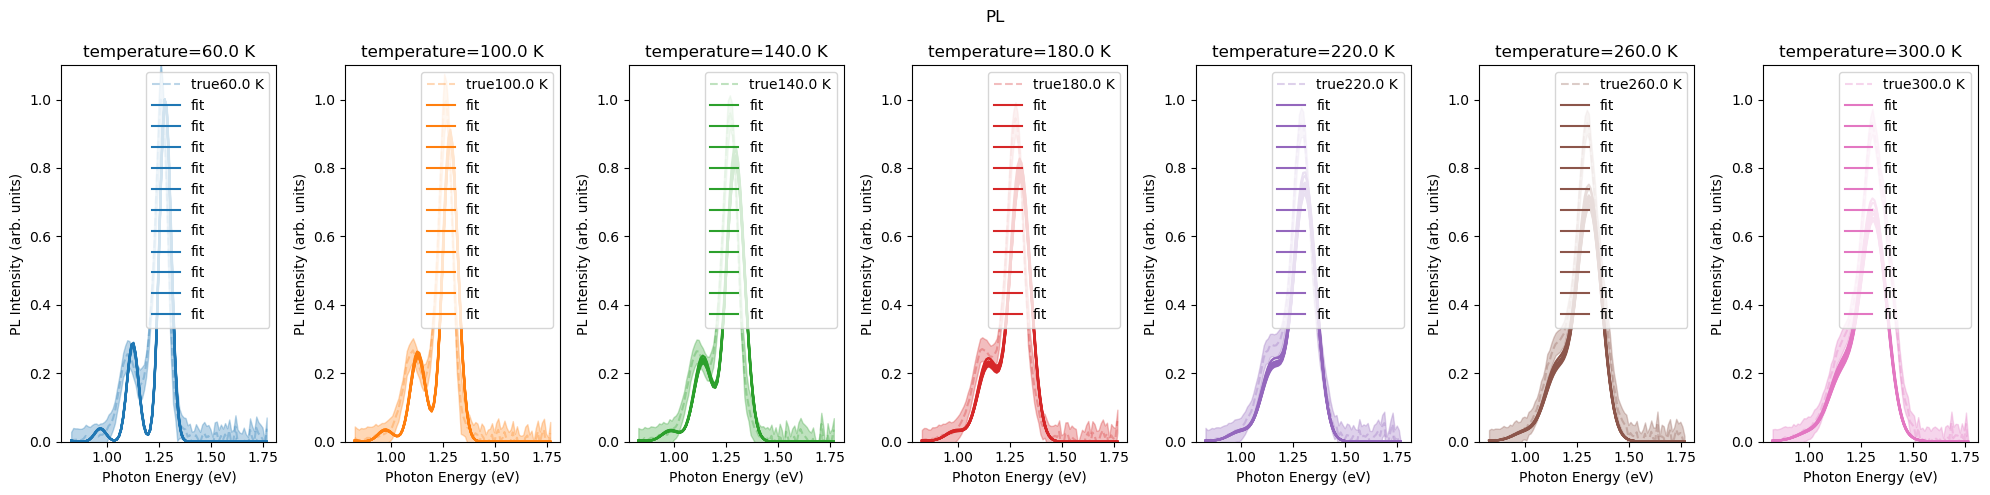

In [69]:
from pl_temp_fit import fit_pl_utils, covariance_utils
import json
def plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=10,
    chains_list=None,
    filter_log_likelihood=False,
):
    """plot the fit to the experimental data
    model_config_save: the model config save dictionary
    model_config: the model config dictionary
    reader: the reader object from the emcee sampler
    discard: the number of samples to discard
    chains_list: the list of chains to plot
    """
    Temp_std_err = model_config_save["Temp_std_err"]
    hws_std_err = model_config_save["hws_std_err"]
    relative_intensity_std_error_pl = model_config_save[
        "relative_intensity_std_error_PL"
    ]
    sigma = model_config_save["sigma"]
    save_folder = model_config_save["save_folder"]
    fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
    params_to_fit_init = model_config_save["params_to_fit_init"]
    min_bounds = model_config_save["min_bounds"]
    max_bounds = model_config_save["max_bounds"]
    csv_name = model_config_save["csv_name_PL"]
    fixed_parameters_dict["EX"]["disorder_ext"] = 2
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
    distribution = reader.get_chain(discard=discard)
    if chains_list is not None:
        distribution = distribution[:, chains_list, :].reshape(
            -1, distribution.shape[-1]
        )
    else:
        distribution = distribution.reshape(-1, distribution.shape[-1])
        if filter_log_likelihood:
            blobs = reader.get_blobs(flat=True, discard=discard)
            distribution = distribution[
                blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
            ]
    true_parameters = fit_pl_utils.get_param_dict(
        params_to_fit_init, distribution[-1]
    )  # model_config_save['params_to_fit_init']#
    co_var_mat_pl, variance_pl = covariance_utils.plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
    fig, ax = fit_pl_utils.plot_exp_data_with_variance(
        temperature_list,
        hws,
        variance_pl,
        save_folder,
        fixed_parameters_dict,
        true_parameters,
        Exp_data,
    )
    for true_parameters in distribution[
        np.random.choice(len(distribution), 10), :
    ]:

        true_parameters = fit_pl_utils.get_param_dict(
            params_to_fit_init, true_parameters
        )

        fig, ax = fit_pl_utils.plot_exp_data_with_variance(
            temperature_list,
            hws,
            variance_pl,
            save_folder,
            fixed_parameters_dict,
            true_parameters,
            Exp_data,
            fig=fig,
            axis=ax,
        )
    return fig, ax
def load_model_config(
    test_id,
    database_folder: Path,
):
    with Path(database_folder,f"{test_id}.json").open("r") as f:
        model_config_save = json.load(f)

    model_config = {
        "Temp_std_err": 0,
        "hws_std_err": 0,
        "relative_intensity_std_error_pl": 0,
        "relative_intensity_std_error_el": 0,
        "sigma": 0,
    }

    for keys in model_config:
        if keys in model_config_save:
            model_config[keys] = model_config_save[keys]


    import os
    if "csv_name_PL" in model_config_save:
       
        csv_name = model_config_save["csv_name_PL"]
        if os.path.exists(csv_name):
            Exp_data, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
                csv_name
            )
            model_config["temperature_list_pl"] = temperature_list_pl
            model_config["hws_pl"] = hws_pl
        else:
            model_config["temperature_list_pl"] = []
            model_config["hws_pl"] = []
    if "csv_name_el" in model_config_save:
       

        csv_name = model_config_save["csv_name_el"]
        if os.path.exists(csv_name):
            Exp_data, temperature_list_el, hws_el = Exp_data_utils.read_data(
                csv_name
            )
            model_config["temperature_list_el"] = temperature_list_el
            model_config["hws_el"] = hws_el
        else:
            model_config["temperature_list_el"] = []
            model_config["hws_el"] = []

    return model_config, model_config_save
model_config, model_config_save = load_model_config(
    test_id, database_folder=databse_path
)
fig, ax = plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=50,
    filter_log_likelihood=False,
)

In [77]:

params_to_fit

{'EX': {'E': array([1.39163353, 0.02447183, 0.06563639, 0.06990072, 0.15632373]),
  'sigma': array([1.39267735, 0.02483257, 0.06722587, 0.06978996, 0.1564248 ]),
  'Li': array([1.3898771 , 0.02436773, 0.0668914 , 0.0688248 , 0.15642385]),
  'Lo': array([1.38814958, 0.02433773, 0.06574361, 0.06734159, 0.15636352]),
  'hO': array([1.39033615, 0.02464864, 0.06617195, 0.06791272, 0.15637636])},
 'CT': {},
 'D': {}}

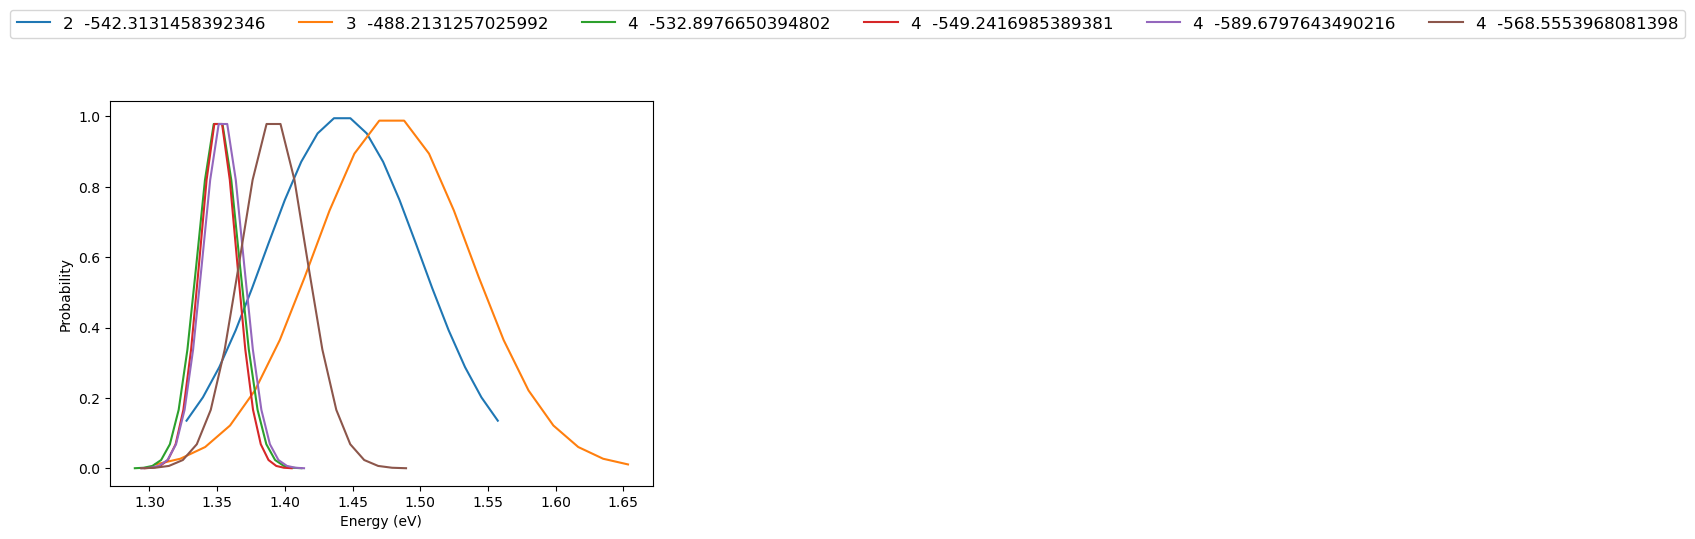

In [94]:
from pl_temp_fit.model_function import LTL
importlib.reload(plot_utils)
fig,ax = plt.subplots(1,1,figsize=(7,5))
color_list = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
counter = -1
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))
for n in range(1,5):

    databse_path = Path("fit_experimental_emcee_PL","fit_data_base",f"n={n}")
    df_all = df_dict[n]
    index_analyse_list = df_all[df_all["csv_name_PL"].str.contains(search_for)][["csv_name_PL", "num_iteration", "max_log_prob"]].index.values
    for i, index_analyse in enumerate(index_analyse_list):
        test_id = df_all["test_id"].loc[index_analyse]
        if df_all["max_log_prob"].loc[index_analyse] <-600: 
            continue
        counter = counter +1    
        label = f"{n}  "+ str (
            df_all["max_log_prob"]
            .loc[index_analyse]
        )
        model_config, model_config_save = config_utils.load_model_config(
            test_id, database_folder=databse_path
        )
        filename = model_config_save["save_folder"] + "/sampler.h5"
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        data = LTL.Data()
        fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
        fixed_parameters_dict["EX"]["disorder_ext"] = n
        params_to_fit = fit_pl_utils.get_param_dict(
            model_config_save["params_to_fit_init"],
            reader.get_chain(discard=5000)[-1][0],
        )
        data.update(**fixed_parameters_dict)
        data.update(**params_to_fit)
        # plot gaussian distribution
        ax.plot(data.EX.DG0, gaussian(data.EX.DG0, data.EX.E, data.EX.sigma),label=label,color=color_list[counter])
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Probability")
ax.legend(loc="center left",ncols=7,bbox_to_anchor=(-0.2, 1.2),fontsize=12)

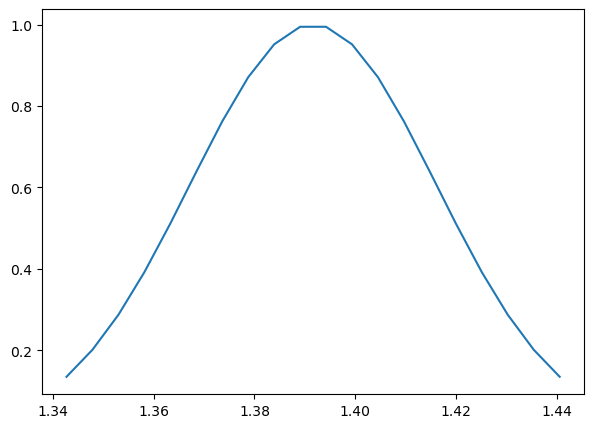

In [85]:
params_to_fit

{'EX': {'E': array([1.39163353, 0.02447183, 0.06563639, 0.06990072, 0.15632373]),
  'sigma': array([1.39267735, 0.02483257, 0.06722587, 0.06978996, 0.1564248 ]),
  'Li': array([1.3898771 , 0.02436773, 0.0668914 , 0.0688248 , 0.15642385]),
  'Lo': array([1.38814958, 0.02433773, 0.06574361, 0.06734159, 0.15636352]),
  'hO': array([1.39033615, 0.02464864, 0.06617195, 0.06791272, 0.15637636])},
 'CT': {},
 'D': {}}